Görüntüyü almak

In [26]:
import os

os.getcwd()

'c:\\Users\\onura\\Documents\\VSproject\\toJava\\PayDayProject'

In [27]:
#ipynb cv2 imshow ile düzhün çalışmıyor o yüzden bir image göstere funcu yazcaz

import matplotlib.pyplot as plt
def imshow(im):
    plt.imshow(im, cmap='gray')
    plt.title("Image")
    plt.axis('off')  # Eksenleri gizle
    plt.show()


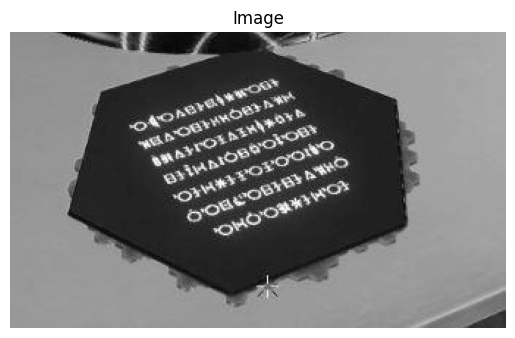

In [28]:
import cv2


# Görüntüyü yükle
image = cv2.imread('tablets\\tablet.jpg')

# Gri tonlamaya çevir
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Görüntüyü özel func ile  ile göster
imshow(gray)




her zaman içi siyah olacağından threshold ile binarization yaptık

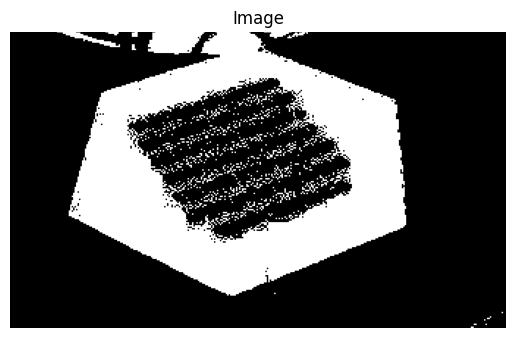

In [63]:
_, binary = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY_INV)
imshow(binary)
# 50 threshold 255 maks 

Tabletin kenarlarını tespit etmek 

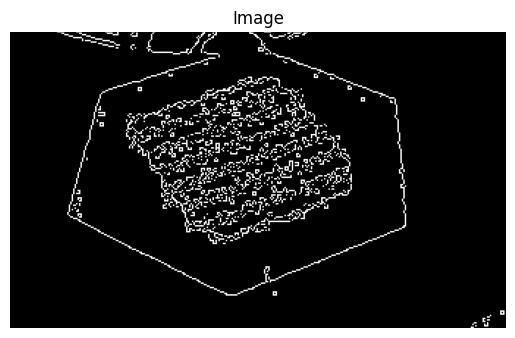

In [71]:
# Kenarları tespit et
edges = cv2.Canny(binary, 50, 150)
imshow(edges)


çok tırtıklı kenarlar hough için problem 

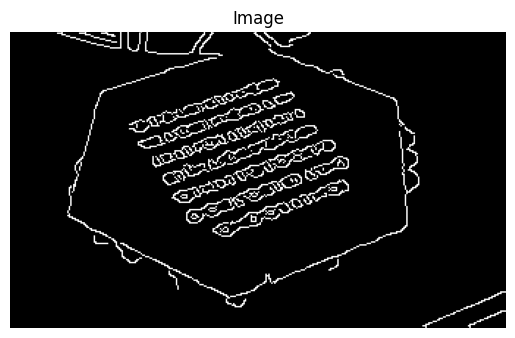

In [110]:
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = cv2.Canny(blurred, 50, 150)
imshow(edges)


Hough ile kenarları düzelt ki hesap olayını çözelim

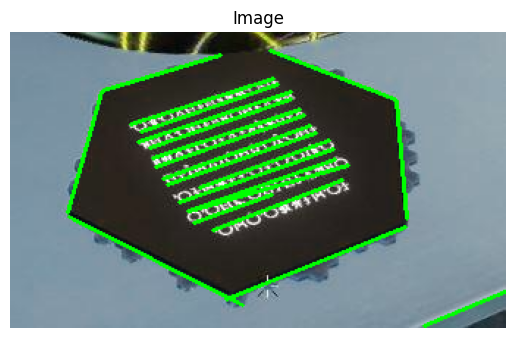

In [111]:
import numpy as np

# Hough dönüşümünü kullanarak çizgileri tespit et
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)

if lines is not None:  # Eğer çizgiler varsa
    # Tespit edilen çizgileri görselleştir
    image_with_lines = image.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    imshow(image_with_lines)
else:
    print("Çizgiler tespit edilmedi.")


elimzideki çizgileri sonsuza dek uzatalım ve bir altıgen oluşturanları tespit edeblim

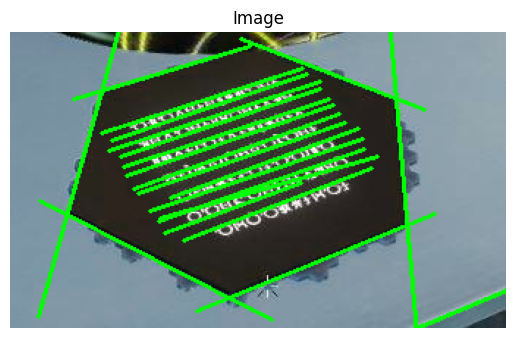

In [123]:
# Çizgileri uzatma fonksiyonu
def extend_line(x1, y1, x2, y2, length=20):
    """Çizgiyi biraz kadar uzat"""
    dx = x2 - x1
    dy = y2 - y1
    slope = dy / dx if dx != 0 else np.inf  # Eğimi hesapla

    # Eğim doğrultusunda çizgiyi uzat
    if slope != np.inf:
        x1_new = int(x1 - length)
        y1_new = int(y1 - length * slope)
        x2_new = int(x2 + length)
        y2_new = int(y2 + length * slope)
    else:
        x1_new, y1_new, x2_new, y2_new = x1, y1 - length, x2, y2 + length

    return x1_new, y1_new, x2_new, y2_new

# Görüntüde çizgileri uzat
image_with_extended_lines = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2)

    # Çizgiyi uzat
    cv2.line(image_with_extended_lines, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 2)

imshow(image_with_extended_lines)

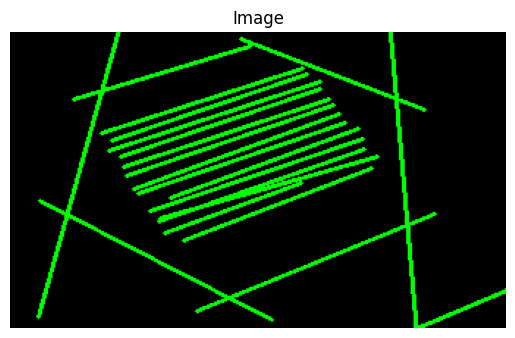

In [124]:
# Görüntüde çizgileri uzat
image_with_extended_lines = np.zeros_like(image)  # Siyah bir arka plan oluştur

for line in lines:
    x1, y1, x2, y2 = line[0]
    x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2)

    # Çizgiyi uzat, yeşil renk (0, 255, 0) kullanarak
    cv2.line(image_with_extended_lines, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 2)

# Çizgileri uzatılmış şekilde göster
imshow(image_with_extended_lines)

artık kesişim noktaları sayesinde bir altıgen arayabiliriz


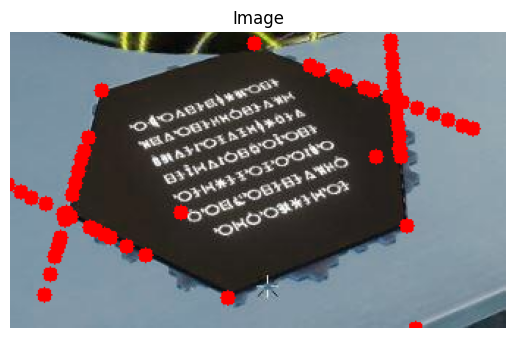

In [121]:
def line_equation(x1, y1, x2, y2):
    """İki nokta arasındaki doğrusal denklemi bul."""
    a = y2 - y1
    b = x1 - x2
    c = a * x1 + b * y1
    return a, b, c

def intersection(line1, line2):
    """İki çizginin kesişim noktasını hesapla."""
    a1, b1, c1 = line_equation(*line1)
    a2, b2, c2 = line_equation(*line2)
    
    determinant = a1 * b2 - a2 * b1
    if determinant == 0:
        return None  # Çizgiler paraleldir

    x = (b2 * c1 - b1 * c2) / determinant
    y = (a1 * c2 - a2 * c1) / determinant
    return (int(x), int(y))

# Kesişim noktalarını hesapla
intersection_points = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        x1, y1, x2, y2 = lines[i][0]
        x1_other, y1_other, x2_other, y2_other = lines[j][0]
        
        # Kesişim hesapla
        point = intersection((x1, y1, x2, y2), (x1_other, y1_other, x2_other, y2_other))
        if point:
            intersection_points.append(point)

# Kesişim noktalarını çiz
image_with_intersections = image.copy()
for point in intersection_points:
    cv2.circle(image_with_intersections, point, 5, (255, 0, 0), -1)

imshow(image_with_intersections)


In [114]:
# Altıgeni tespit etme
def is_hexagon(points):
    """Verilen 6 nokta ile altıgenin oluşup oluşmadığını kontrol et."""
    if len(points) != 6:
        return False
    
    # Noktalar arasındaki mesafeleri kontrol et
    distances = []
    for i in range(6):
        for j in range(i+1, 6):
            distance = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            distances.append(distance)
    
    # Mesafeler birbirine yakın olmalı
    distances = np.array(distances)
    if np.std(distances) < 10:  # Mesafeler arasındaki fark küçükse
        return True
    return False

# Kesişim noktalarından altıgeni bul
if len(intersection_points) >= 6:
    # İlk 6 noktayı al ve altıgeni tespit et
    hexagon_points = intersection_points[:6]

    if is_hexagon(hexagon_points):
        print("Altıgen tespit edildi!")
        # Altıgeni çiz
        for i in range(6):
            cv2.line(image_with_intersections, hexagon_points[i], hexagon_points[(i + 1) % 6], (0, 255, 255), 2)

        imshow(image_with_intersections)
    else:
        print("Altıgen tespit edilemedi.")
else:
    print("Yeterli sayıda kesişim noktası yok.")

Altıgen tespit edilemedi.


Tablet açısını hesaplama vaktiii 

In [44]:
def calculate_angle(line):
    # Line (x1, y1) -> (x2, y2) formatında
    x1, y1, x2, y2 = line
    delta_y = y2 - y1
    delta_x = x2 - x1
    angle = np.arctan2(delta_y, delta_x) * 180 / np.pi  # Derece cinsinden
    return angle

# Eğilim açılarını hesapla
angles = [calculate_angle(line[0]) for line in lines]

print(angles)

[-17.15242174021183, 25.93080646265187, -22.12194197188185, 20.955776730632184, -19.241878278024384, -45.0, 85.39990433373671, -74.98163936884933, -16.94922423382144, -22.579572564026304, -18.939004260240065, -20.0260890941166, -20.992853373114194, -22.96377305985455, -18.76806006684338, -14.931417178137556, -17.764853300697478, -15.642246457208728, -20.684080267946808, -18.970407808486545, -15.36161631184866, -15.945395900922856, -19.057704510128328, -18.939004260240065, -18.811889302519145, -18.08344538304866, -16.85839876773828, -17.801872051490882]


In [45]:
# 4 köşe koordinatlarını tespit et
# Bu köşeleri manuel tespit edebilir ya da kenarları analize ederek bulabilirsin.

# Perspektif dönüşüm matrisi
pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])  # Mevcut dört köşe
pts2 = np.float32([[0, 0], [w, 0], [w, h], [0, h]])  # Yeni düz form

# Perspektif dönüşüm matrisi hesapla
matrix = cv2.getPerspectiveTransform(pts1, pts2)

# Perspektif dönüşümü uygula
result = cv2.warpPerspective(image, matrix, (width, height))


NameError: name 'x3' is not defined